In [30]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from functools import partial
from os.path import join as oj
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity

import imodels
from imodels.util import data_util
from imodels.discretization import discretizer, simple

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.dpi'] = 250

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate
# from local_models.stable import StableLinearClassifier as stbl_local
# from experiments.util import get_comparison_result

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
class TransferTree:

    def __init__(self, num_groups: int, *args, **kwargs):
        self.trees = [
            DecisionTreeClassifier(*args, **kwargs) for _ in range(num_groups)
        ]

    def fit(self, X, y, sample_weights):
        for tree, weight in zip(self.trees, sample_weights):
            tree.fit(X, y, weight)
        return self

    def predict(self, X, subgroups):
        preds = np.zeros(X.shape[0])
        for tree, subgroup in zip(self.trees, subgroups):
            preds[subgroup] = tree.predict(X[subgroup])
        return preds
    
    def predict_proba(self, X, subgroups):
        preds_proba = np.zeros((X.shape[0], 2))
        for tree, subgroup in zip(self.trees, subgroups):
            preds_proba[subgroup] = tree.predict_proba(X[subgroup])
        return preds_proba


def print_results(model, X_test, y_test, test_subgroups):
    if isinstance(model, TransferTree):
        pred_proba_args = (X_test, test_subgroups)
        tree_0 = model.trees[0]
        tree_1 = model.trees[1]
    else:
        pred_proba_args = (X_test,)
        tree_0, tree_1 = model, model

    spec_scorer = validate.make_best_spec_high_sens_scorer(0.95)
    print('spec: ', spec_scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]))
    print('APC: ', metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1]))
    print('AUC: ', metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1]))

    # y_test_0, y_test_1 = y_test[~test_subgroups[1]], y_test[test_subgroups[1]]
    # X_test_0, X_test_1 = X_test[~test_subgroups[1]], X_test[test_subgroups[1]]

    # y_score_0 = tree_0.predict_proba(X_test_0)[:, 1]
    # print('group 0 spec: ', spec_scorer(y_test_0, y_score_0))
    # print('group 0 APC: ', metrics.average_precision_score(y_test_0, y_score_0))
    # print('group 0 AUC: ', metrics.roc_auc_score(y_test_0, y_score_0))

    # y_score_1 = tree_1.predict_proba(X_test_1)[:, 1]
    # print('group 1 spec: ', spec_scorer(y_test_1, y_score_1))
    # print('group 1 APC: ', metrics.average_precision_score(y_test_1, y_score_1))
    # print('group 1 AUC: ', metrics.roc_auc_score(y_test_1, y_score_1))


In [32]:
X, y, feature_names = data_util.get_clean_dataset('csi_with_meta_keys.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)
X_df_clean = X_df.drop(columns=['SITE', 'AgeInYears'])
X, feature_names = X_df_clean.values, X_df_clean.columns.values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=2)

## age split

In [34]:
def get_subgroups_age(df, cutoff = 4):
    max = df['AgeInYears'].max()
    is_group_1 = df['AgeInYears'] > cutoff
    p_group_1 = 0.5 / cutoff * df['AgeInYears']
    p_group_1[is_group_1] = 0.5 / (max - cutoff) * (df.loc[is_group_1, 'AgeInYears'] - cutoff) + 0.5
    return is_group_1, p_group_1

is_group_1, p_group_1 = get_subgroups_age(X_df, 7)
is_group_1_train, is_group_1_test, p_group_1_train, p_group_1_test = model_selection.train_test_split(
    is_group_1, p_group_1, random_state=2)
age_groups_test = [~is_group_1_test, is_group_1_test]
# age_groups_train, age_groups_test = zip(*[
#     model_selection.train_test_split(group, random_state=2) for group in age_groups])

In [36]:
dtree_args = {'max_leaf_nodes': 8, 'class_weight': {0: 1, 1: 6}, 'random_state': 0}

### plain cart

In [37]:
cart = DecisionTreeClassifier(max_leaf_nodes=16, class_weight={0: 1, 1: 6})
cart.fit(X_train, y_train)
print_results(cart, X_test, y_test, age_groups_test)

spec:  0.004341534008683068
APC:  0.3850632074339372
AUC:  0.7852828289183916


### two trees, no transfer

In [38]:
age_sample_weights_train = [(~is_group_1_train).astype(int), is_group_1_train.astype(int)]
subcart_no_transfer = TransferTree(2, **dtree_args)
subcart_no_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(subcart_no_transfer, X_test, y_test, age_groups_test)

spec:  0.14182344428364688
APC:  0.39299643947229146
AUC:  0.7772551857211771


### linear transfer

In [39]:
age_sample_weights_train = [1 - p_group_1_train, p_group_1_train]
linear_transfer = TransferTree(2, **dtree_args)
linear_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(linear_transfer, X_test, y_test, age_groups_test)

spec:  0.13748191027496381
APC:  0.3819664167355267
AUC:  0.7824199333039703


### linear one-way transfer (higher -> lower)

In [40]:
age_sample_weights_train = [1 - p_group_1_train, is_group_1_train.astype(int)]
linear_onew = TransferTree(2, **dtree_args)
linear_onew.fit(X_train, y_train, age_sample_weights_train)
print_results(linear_onew, X_test, y_test, age_groups_test)

spec:  0.13748191027496381
APC:  0.3819664167355267
AUC:  0.7824199333039703


### density transfer

In [41]:
# kde = KernelDensity()
# kde.fit(np.expand_dims(X_df['AgeInYears'].values, axis=1))
# np.exp(kde.score([[14]]))

<AxesSubplot:xlabel='AgeInYears', ylabel='Density'>

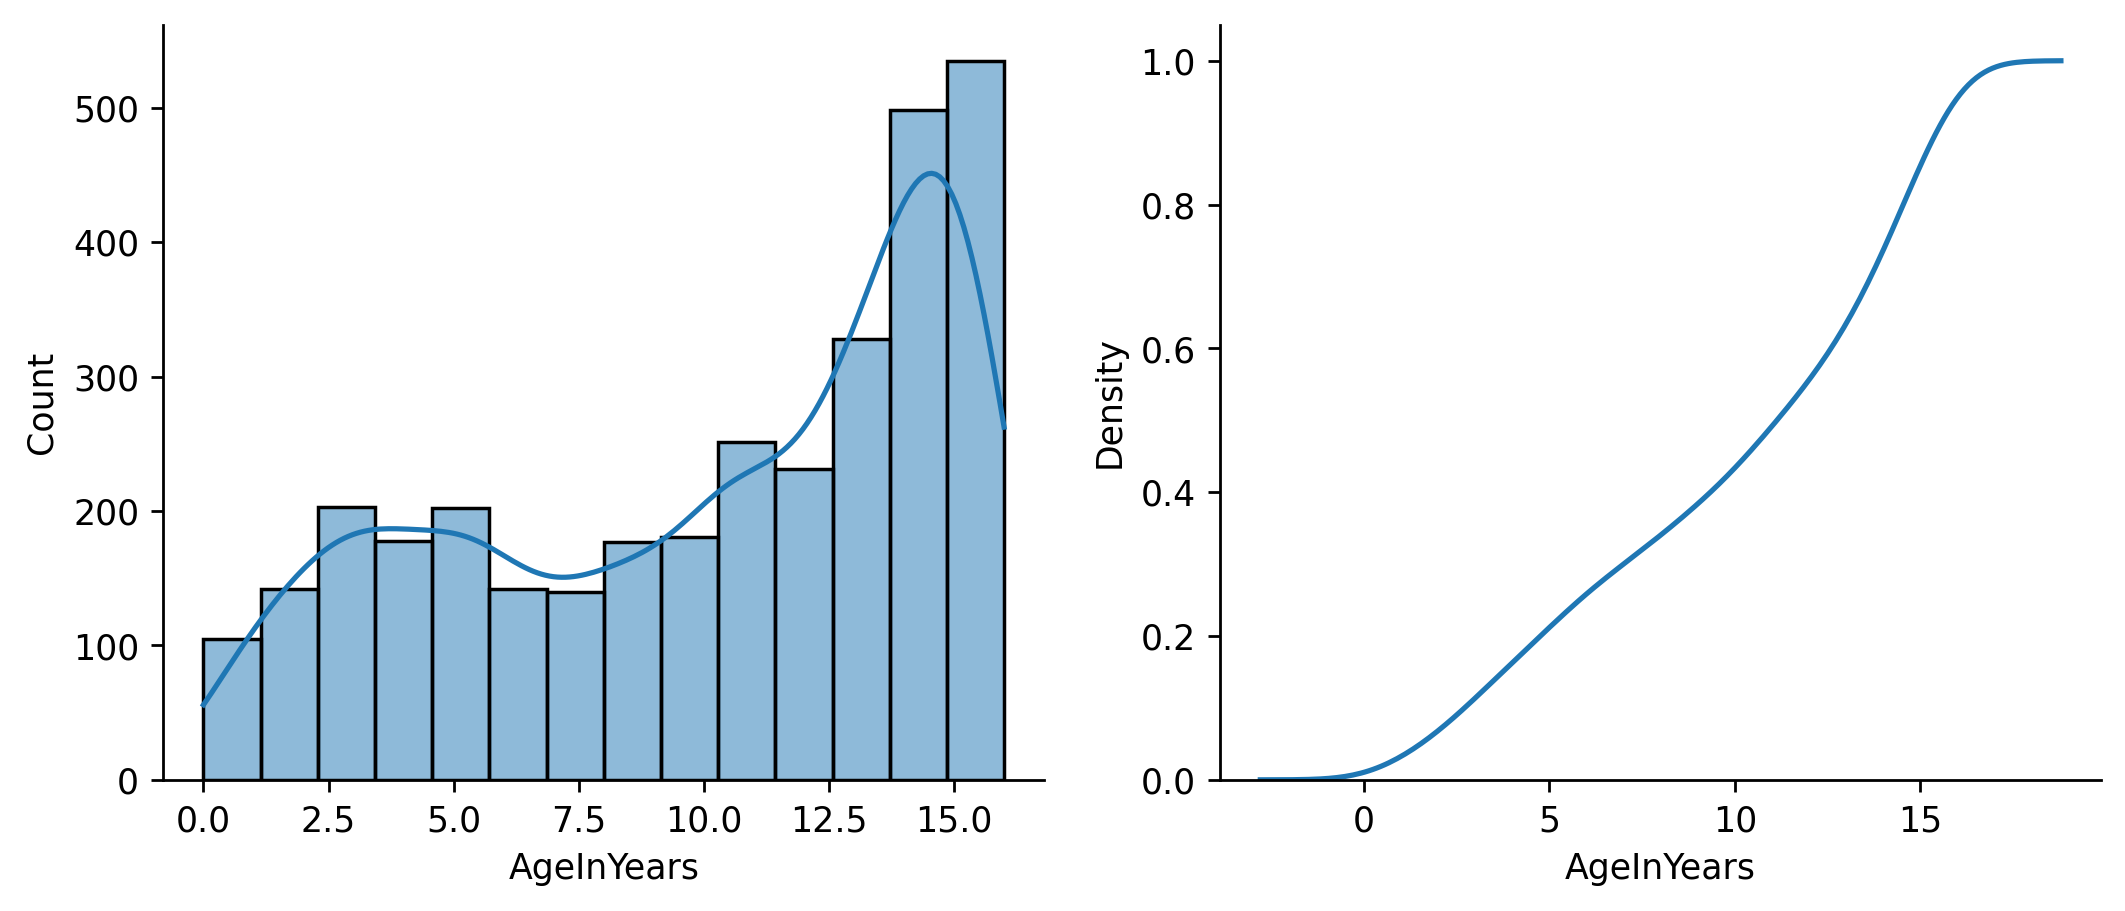

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(X_df['AgeInYears'], ax=axes[0], kde=True)
sns.kdeplot(X_df['AgeInYears'], cumulative=True, ax=axes[1])

In [43]:
cdf_x, cdf_y = axes[1].lines[0].get_xdata(), axes[1].lines[0].get_ydata()
def kde_cdf(x):
    return cdf_y[np.searchsorted(cdf_x, x)]

In [44]:
p_group_1_sig = X_df['AgeInYears'].apply(kde_cdf)
p_group_1_sig_train, p_group_1_sig_test = model_selection.train_test_split(
    p_group_1_sig, random_state=0)
age_sample_weights_train = [1 - p_group_1_sig_train, p_group_1_sig_train]

In [45]:
kde_transfer = TransferTree(2, **dtree_args)
kde_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(kde_transfer, X_test, y_test, age_groups_test)

spec:  0.2735166425470333
APC:  0.37708172686278874
AUC:  0.784396694561547


### sigmoidal transfer

In [46]:
p_group_1_sig = 1 / (1 + np.exp(-5 * (X_df['AgeInYears'] - 7)))
p_group_1_sig_train, p_group_1_sig_test = model_selection.train_test_split(p_group_1_sig, random_state=0)
age_sample_weights_train = [1 - p_group_1_sig_train, p_group_1_sig_train]

In [47]:
sig_transfer = TransferTree(2, **dtree_args)
sig_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(sig_transfer, X_test, y_test, age_groups_test)

spec:  0.13748191027496381
APC:  0.3723711184671986
AUC:  0.7828236749931836


### sigmoidal one-way transfer (higher -> lower)\

In [48]:
age_sample_weights_train = [1 - p_group_1_sig_train, is_group_1_train.astype(int)]
sig_onew = TransferTree(2, **dtree_args)
sig_onew.fit(X_train, y_train, age_sample_weights_train)
print_results(sig_onew, X_test, y_test, age_groups_test)

spec:  0.13748191027496381
APC:  0.3729538782757635
AUC:  0.785240881729902


### step transfer

In [49]:
p_group_1_sig_train = is_group_1_train.astype(int) * 0.6
p_group_1_sig_train[p_group_1_sig_train == 0] = 0.4
age_sample_weights_train = [1 - p_group_1_sig_train, p_group_1_sig_train]

In [50]:
step_transfer = TransferTree(2, **dtree_args)
step_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(step_transfer, X_test, y_test, age_groups_test)

spec:  0.13748191027496381
APC:  0.3918771209313332
AUC:  0.7979770968350846


## site split

In [52]:
n_sites = X_df['SITE'].unique().shape[0]
site_groups = [
    X_df['SITE'] == site for site in X_df['SITE'].unique()]
site_groups_train, site_groups_test = zip(*[
    model_selection.train_test_split(group, random_state=2) for group in site_groups])
dtree_args['max_leaf_nodes'] = 4

### plain cart

In [53]:
cart = DecisionTreeClassifier(max_leaf_nodes=n_sites * 4, class_weight={0: 1, 1: 6}, random_state=0)
cart.fit(X_train, y_train)
print_results(cart, X_test, y_test, age_groups_test)

spec:  0
APC:  0.37602550063137025
AUC:  0.7518928668805973


### |sites| trees, no transfer

In [54]:
site_sample_weights_train = [group.astype(int) for group in site_groups_train]
subcart_no_transfer = TransferTree(n_sites, **dtree_args)
subcart_no_transfer.fit(X_train, y_train, site_sample_weights_train)
print_results(subcart_no_transfer, X_test, y_test, site_groups_test)

spec:  0.08104196816208394
APC:  0.31733059551100673
AUC:  0.6948918811216678


### step transfer

In [55]:
site_sample_weights_train = [group.astype(int).replace({0: 0.5}) for group in site_groups_train]
step_transfer = TransferTree(17, **dtree_args)
step_transfer.fit(X_train, y_train, site_sample_weights_train)
print_results(step_transfer, X_test, y_test, site_groups_test)

spec:  0.3921852387843705
APC:  0.3714990400734532
AUC:  0.7709368904549172
